<a href="https://colab.research.google.com/github/raajds/FakeNews_LSTM/blob/main/NLP_Fake_News_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [131]:
# Scope : This complete  Project is about fake news classifications through NLP 
# Language : Using Python and supporting packages and api, we will try to build this classification model 
# NLp : this is text news para, so we need to use python supporitng NLP packages 
# As per analysis we have independent variables and one that label column in data is called target
# classification, thought implementation is, we have title, author & text feature, since understanding
# is to classify Fake news to we will try to merge ‘title’ and ‘text’ and create on merged column.    

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import re
from string import punctuation
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional,Dropout
from tensorflow.keras.models import Model




In [3]:
# Data we have good data size , local PC is not supporting to algorithm execuation (memory issue),
# hence using google drive and google colab, in this section mounted my google drive in code
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [132]:
# Through pandas , we are loading data from CSV in df_train data frame  & provided test.csv as df_test
df_train = pd.read_csv('/content/drive/MyDrive/data/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/data/test.csv')

In [133]:
# Just to check whether data are loaded or not? We have used head, will give us default number of records
# A.1 : It is EDA steps in data science
df_train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [134]:
df_test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [135]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [136]:
# This count will provide us the number of real (0) & Fake (1) news , seems almost balanced data 
# it will help us to understand that our dataset given is almost normally distributed with result.
df_train.label.value_counts()

1    10413
0    10387
Name: label, dtype: int64

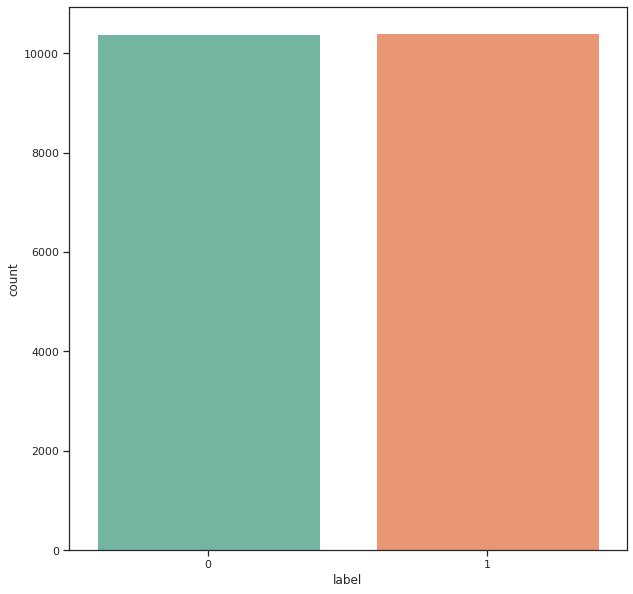

In [137]:
# To check whether True News and Fake News are balanced or not if not then need to work on Sampling technieue for traing dataset.
# It is balanced 
plt.rcParams['figure.figsize'] = [10, 10]
sns.set_theme(style="ticks")
sns.countplot(x='label', data=df_train, palette='Set2')
plt.show()

In [138]:
# Combining Title And Text Together : As this is part of news and title can also help us to guess whether news is True or not
# We have loaded both Train dataset and Test dataset from CSV and combined each in segment
df_train['original'] = df_train['title']+ ' '+ df_train['text']
df_test['original'] = df_test['title']+ ' '+ df_test['text']

In [139]:
df_train['original'][130]

'Pelosi: Republicans Should Tell Trump He’s ’Bringing Dishonor’ to the Presidency - Breitbart House Minority Leader Rep. Nancy Pelosi ( ) Saturday on MSNBC’s “AM Joy” called on “some adults in the Republican Party” stand up to President Donald Trump and tell him that he is “bringing dishonor” to the presidency.  “[W]e have a crazy system here where we have a president who is tweeting things on the basis of very little knowledge, but that isn’t a problem for him,” Pelosi told host Joy Reid. “So, really I think that there should be some adults in the Republican Party who would say, ‘Please, you bring dishonor to the office of the president by making it look like it’s a personal acquisition of yours.’ No, it is a public responsibility. Honor it. ” Follow Trent Baker on Twitter @MagnifiTrent'

In [140]:
df_test['original'][0]

'Specter of Trump Loosens Tongues, if Not Purse Strings, in Silicon Valley - The New York Times PALO ALTO, Calif.  —   After years of scorning the political process, Silicon Valley has leapt into the fray. The prospect of a President Donald J. Trump is pushing the tech community to move beyond its traditional role as donors and to embrace a new existence as agitators and activists. A distinguished venture capital firm emblazoned on its corporate home page an earthy   epithet. One prominent tech chieftain says the consequences of Mr. Trump’s election would “range between disastrous and terrible. ” Another compares him to a dictator. And nearly 150 tech leaders signed an open letter decrying Mr. Trump and his campaign of “anger” and “bigotry. ” Not quite all the action is  . Peter Thiel, a founder of PayPal and Palantir who was the first outside investor in Facebook, spoke at the Republican convention in July. The New York Times reported on Saturday that Mr. Thiel is giving $1. 25 millio

In [141]:
# Stopwords are the English words which does not add much meaning to a sentence. 
# They can safely be ignored without sacrificing the meaning of the sentence. 
# For example, the words like the, he, have etc. Such words are already captured
# this in corpus named corpus

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [142]:
# Collecting some additional Stopwords from nltk
stop_words = stopwords.words('english')
stop_words.extend(['from','subject','re','edu','use'])


In [15]:
#------------------------------------------------------------------------
SPECIAL_TOKENS = {
    'quoted': 'quoted_item',
    'non-ascii': 'non_ascii_word',
    'undefined': 'something'
}

def clean(text, stem_words=True):

    
    def pad_str(s):
        return ' '+s+' '
    
    if pd.isnull(text):
        return ''

#    stops = set(stopwords.words("english"))
    # Clean the text, with the option to stem words.
    
    # Empty question
    
    if type(text) != str or text=='':
        return ''

    # Clean the text
    text = re.sub("\'s", " ", text) # we have cases like "Sam is" or "Sam's" (i.e. his) these two cases aren't separable, I choose to compromise are kill "'s" directly
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("can't", "can not", text)
    text = re.sub("Didn’t", "did not", text,flags=re.IGNORECASE)
    text = re.sub("n't", " not ", text)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    text = re.sub("b\.g\.", " bg ", text, flags=re.IGNORECASE)
    text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?United State(s)?", " America ", text, flags=re.IGNORECASE)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)
    text = re.sub("\n", "",text,flags=re.IGNORECASE)
    text = re.sub('.(-+)', ',', text)  ##replaces dashes
    text = re.sub('(  +)', ',', text)  #extra spaces
    
    # remove comma between numbers, i.e. 15,000 -> 15000
    
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    

    
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)
    text = re.sub('\#', " hasha ", text)
    text = re.sub('\@', " attherate ", text)
    

    
    # indian dollar
    
    text = re.sub("(?<=[0-9])rs ", " rs ", text, flags=re.IGNORECASE)
    text = re.sub(" rs(?=[0-9])", " rs ", text, flags=re.IGNORECASE)
    
    text = re.sub(r" (the[\s]+|The[\s]+)?US(A)? ", " America ", text)
    
    
    # replace the float numbers with a random number, it will be parsed as number afterward, and also been replaced with word "number"
    
    text = re.sub('[0-9]+\.[0-9]+', " 87 ", text)

    pattern = '[^a-zA-Z\s]|(?i)archived'
    text = re.sub(pattern, '', text)
  
    
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation]).lower()
       # Return a list of words
    return text

In [143]:
# Applying cleaning of original sentence through we can remove expressions and special characters for both train and test dataset.
# After cleaning storing data on same data frame column
df_train['original'] = df_train['original'].apply(clean)
df_test['original'] = df_test['original'].apply(clean)

In [144]:
df_train['original'][130]

'pelosi republicans should tell trump hes bringing dishonor to the presidency breitbart house minority leader rep nancy pelosi   saturday on msnbcs am joy called on some adults in the republican party stand up to president donald trump and tell him that he is bringing dishonor to the presidencywe have a crazy system here where we have a president who is tweeting things on the basis of very little knowledge but that isnt a problem for him pelosi told host joy reid so really i think that there should be some adults in the republican party who would say please you bring dishonor to the office of the president by making it look like its a personal acquisition of yours no it is a public responsibility honor it  follow trent baker on twitter  attherate magnifitrent'

In [145]:
df_test['original'][0]

'specter of trump loosens tongues if not purse strings in silicon valley the new york times palo alto califafter years of scorning the political process silicon valley has leapt into the fray the prospect of a president donald j trump is pushing the tech community to move beyond its traditional role as donors and to embrace a new existence as agitators and activists a distinguished venture capital firm emblazoned on its corporate home page an earthyepithet one prominent tech chieftain says the consequences of mr trumps election would range between disastrous and terrible  another compares him to a dictator and nearly  tech leaders signed an open letter decrying mr trump and his campaign of anger and bigotry  not quite all the action is peter thiel a founder of paypal and palantir who was the first outside investor in facebook spoke at the republican convention in july the new york times reported on saturday that mr thiel is giving  dollar   million to support mr trumps candidacy even a

In [146]:

# Removing Stopwords And Remove Words With 2 Or Less Characters : Most of the words which are meaning full in English
# has more than 2 or 3 characters word , so removing less will have to extract meaning full words
# return from function : This function will return list with more than 3 char words
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)
            
    return result

In [147]:
# Applying The Function To The Dataframe : it will apply the function objective over specific column
# applying prerpocessing function to the given train data frame and then storing over new column, 
# this clean column(list) will have token as string, this each token will have some meaning
df_train['clean'] = df_train['original'].apply(preprocess)

In [148]:
# Applying The Function To The Dataframe : it will apply the function objective over specific column
# applying prerpocessing function to the given test data frame and then storing over new column called clean,
# this clean column (list) will have token as string, this each token will have some meaning
df_test['clean'] = df_test['original'].apply(preprocess)

In [149]:
# Showing Original News befor preprocessing 
df_train['original'][0]

'house dem aide we did not even see comeys letter until jason chaffetz tweeted it house dem aide we did not even see comeys letter until jason chaffetz tweeted it by darrell lucus on october   subscribe jason chaffetz on the stump in american fork utah  image courtesy michael jolley available under a creative commonby license with apologies to keith olbermann there is no doubt who the worst person in the world is this weekfbi director james comey but according to a house democratic aide it looks like we also know who the seconworst person is as well it turns out that when comey sent his noinfamous letter announcing that the fbi was looking into emails that may be related to hillary clintons email server the ranking democrats on the relevant committees did not hear about it from comey they found out via a tweet from one of the republican committee chairmen as we now know comey notified the republican chairmen and democratic ranking members of the house intelligence judiciary and oversig

In [150]:
# new added column called 'clean' after preprocessing  as list of words as token
df_train['clean'][0]

['house',
 'aide',
 'comeys',
 'letter',
 'jason',
 'chaffetz',
 'tweeted',
 'house',
 'aide',
 'comeys',
 'letter',
 'jason',
 'chaffetz',
 'tweeted',
 'darrell',
 'lucus',
 'october',
 'subscribe',
 'jason',
 'chaffetz',
 'stump',
 'american',
 'fork',
 'utah',
 'image',
 'courtesy',
 'michael',
 'jolley',
 'available',
 'creative',
 'commonby',
 'license',
 'apologies',
 'keith',
 'olbermann',
 'doubt',
 'worst',
 'person',
 'world',
 'weekfbi',
 'director',
 'james',
 'comey',
 'according',
 'house',
 'democratic',
 'aide',
 'looks',
 'like',
 'know',
 'seconworst',
 'person',
 'turns',
 'comey',
 'sent',
 'noinfamous',
 'letter',
 'announcing',
 'looking',
 'emails',
 'related',
 'hillary',
 'clintons',
 'email',
 'server',
 'ranking',
 'democrats',
 'relevant',
 'committees',
 'hear',
 'comey',
 'tweet',
 'republican',
 'committee',
 'chairmen',
 'know',
 'comey',
 'notified',
 'republican',
 'chairmen',
 'democratic',
 'ranking',
 'members',
 'house',
 'intelligence',
 'judiciar

In [214]:
# Showing Cleaned Up News After Removing Stopwords
print(df_train['clean_lema'][0])

['house', 'aide', 'comeys', 'letter', 'jason', 'chaffetz', 'tweeted', 'house', 'aide', 'comeys', 'letter', 'jason', 'chaffetz', 'tweeted', 'darrell', 'lucus', 'october', 'subscribe', 'jason', 'chaffetz', 'stump', 'american', 'fork', 'utah', 'image', 'courtesy', 'michael', 'jolley', 'available', 'creative', 'commonby', 'license', 'apology', 'keith', 'olbermann', 'doubt', 'worst', 'person', 'world', 'weekfbi', 'director', 'james', 'comey', 'according', 'house', 'democratic', 'aide', 'look', 'like', 'know', 'seconworst', 'person', 'turn', 'comey', 'sent', 'noinfamous', 'letter', 'announcing', 'looking', 'email', 'related', 'hillary', 'clinton', 'email', 'server', 'ranking', 'democrat', 'relevant', 'committee', 'hear', 'comey', 'tweet', 'republican', 'committee', 'chairman', 'know', 'comey', 'notified', 'republican', 'chairman', 'democratic', 'ranking', 'member', 'house', 'intelligence', 'judiciary', 'oversight', 'committee', 'agency', 'reviewing', 'email', 'recently', 'discovered', 'order

In [215]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [216]:
# Lemmatization reduces words to their base word, which is linguistically 
# correct lemmas. It transforms root word with the use of vocabulary and
# morphological analysis. Lemmatization is usually more sophisticated than
# stemming
from nltk.stem.wordnet import WordNetLemmatizer
def lemaClean(cleanWordslema):
  lem = WordNetLemmatizer()
  lema_words = []
  for l in cleanWordslema:
    lema_words.append(lem.lemmatize(l))
  return lema_words
     

In [217]:
# Calling lema function on the column for train.csv & would conver our train data into root meaning data
df_train['clean_lema'] = df_train['clean'].apply(lemaClean)

In [218]:
# Calling lema function on the column for test.csv & would conver our train data into root meaning data
df_test['clean_lema'] = df_test['clean'].apply(lemaClean)

In [219]:
print(df_test['clean'][0])

['specter', 'trump', 'loosens', 'tongues', 'purse', 'strings', 'silicon', 'valley', 'york', 'times', 'palo', 'alto', 'califafter', 'years', 'scorning', 'political', 'process', 'silicon', 'valley', 'leapt', 'fray', 'prospect', 'president', 'donald', 'trump', 'pushing', 'tech', 'community', 'traditional', 'role', 'donors', 'embrace', 'existence', 'agitators', 'activists', 'distinguished', 'venture', 'capital', 'firm', 'emblazoned', 'corporate', 'home', 'page', 'earthyepithet', 'prominent', 'tech', 'chieftain', 'says', 'consequences', 'trumps', 'election', 'range', 'disastrous', 'terrible', 'compares', 'dictator', 'nearly', 'tech', 'leaders', 'signed', 'open', 'letter', 'decrying', 'trump', 'campaign', 'anger', 'bigotry', 'action', 'peter', 'thiel', 'founder', 'paypal', 'palantir', 'outside', 'investor', 'facebook', 'spoke', 'republican', 'convention', 'july', 'york', 'times', 'reported', 'saturday', 'thiel', 'giving', 'dollar', 'million', 'support', 'trumps', 'candidacy', 'supporters', '

In [220]:
print(df_test['clean_lema'][0])

['specter', 'trump', 'loosens', 'tongue', 'purse', 'string', 'silicon', 'valley', 'york', 'time', 'palo', 'alto', 'califafter', 'year', 'scorning', 'political', 'process', 'silicon', 'valley', 'leapt', 'fray', 'prospect', 'president', 'donald', 'trump', 'pushing', 'tech', 'community', 'traditional', 'role', 'donor', 'embrace', 'existence', 'agitator', 'activist', 'distinguished', 'venture', 'capital', 'firm', 'emblazoned', 'corporate', 'home', 'page', 'earthyepithet', 'prominent', 'tech', 'chieftain', 'say', 'consequence', 'trump', 'election', 'range', 'disastrous', 'terrible', 'compare', 'dictator', 'nearly', 'tech', 'leader', 'signed', 'open', 'letter', 'decrying', 'trump', 'campaign', 'anger', 'bigotry', 'action', 'peter', 'thiel', 'founder', 'paypal', 'palantir', 'outside', 'investor', 'facebook', 'spoke', 'republican', 'convention', 'july', 'york', 'time', 'reported', 'saturday', 'thiel', 'giving', 'dollar', 'million', 'support', 'trump', 'candidacy', 'supporter', 'flee', 'recentl

In [193]:
# Stemming RSA : Not in used as used lema
from nltk.stem import PorterStemmer

def Stemming(cleanWords):
  ps = PorterStemmer()
 
  stemmed_words=[]
  for w in cleanWords:
      stemmed_words.append(ps.stem(w))
  return stemmed_words

In [221]:

# Obtaining The Total Words Present In The Dataset
# we have list of list hence as per big O notation the Complexity will be n square
list_of_words = []
for i in df_train.clean_lema:
    for j in i:
        list_of_words.append(j)

In [222]:
list_of_words

['house',
 'aide',
 'comeys',
 'letter',
 'jason',
 'chaffetz',
 'tweeted',
 'house',
 'aide',
 'comeys',
 'letter',
 'jason',
 'chaffetz',
 'tweeted',
 'darrell',
 'lucus',
 'october',
 'subscribe',
 'jason',
 'chaffetz',
 'stump',
 'american',
 'fork',
 'utah',
 'image',
 'courtesy',
 'michael',
 'jolley',
 'available',
 'creative',
 'commonby',
 'license',
 'apology',
 'keith',
 'olbermann',
 'doubt',
 'worst',
 'person',
 'world',
 'weekfbi',
 'director',
 'james',
 'comey',
 'according',
 'house',
 'democratic',
 'aide',
 'look',
 'like',
 'know',
 'seconworst',
 'person',
 'turn',
 'comey',
 'sent',
 'noinfamous',
 'letter',
 'announcing',
 'looking',
 'email',
 'related',
 'hillary',
 'clinton',
 'email',
 'server',
 'ranking',
 'democrat',
 'relevant',
 'committee',
 'hear',
 'comey',
 'tweet',
 'republican',
 'committee',
 'chairman',
 'know',
 'comey',
 'notified',
 'republican',
 'chairman',
 'democratic',
 'ranking',
 'member',
 'house',
 'intelligence',
 'judiciary',
 'ove

In [223]:
len(list_of_words)

7382471

In [224]:

# Obtaining The Total Number Of Unique Words : we need this unique words to create our corpus
total_words = len(list(set(list_of_words)))
total_words

241613

In [225]:
# Joining The Words Into A String : we have list of individul words , below apply will help us to concat string and create sentence.
df_train['clean_joined'] = df_train['clean_lema'].apply(lambda x: " ".join(x))

In [226]:
df_test['clean_joined'] = df_test['clean_lema'].apply(lambda x: " ".join(x))

In [227]:
df_train['clean_joined'][0]

'house aide comeys letter jason chaffetz tweeted house aide comeys letter jason chaffetz tweeted darrell lucus october subscribe jason chaffetz stump american fork utah image courtesy michael jolley available creative commonby license apology keith olbermann doubt worst person world weekfbi director james comey according house democratic aide look like know seconworst person turn comey sent noinfamous letter announcing looking email related hillary clinton email server ranking democrat relevant committee hear comey tweet republican committee chairman know comey notified republican chairman democratic ranking member house intelligence judiciary oversight committee agency reviewing email recently discovered order contained classified information long letter went oversight committee chairman jason chaffetz political world ablaze tweet informed learned existence email appear pertinent investigation case reopened jason chaffetz attherate jasoninthehouse october course know case comey actual

In [228]:
df_train['original'][0]

'house dem aide we did not even see comeys letter until jason chaffetz tweeted it house dem aide we did not even see comeys letter until jason chaffetz tweeted it by darrell lucus on october   subscribe jason chaffetz on the stump in american fork utah  image courtesy michael jolley available under a creative commonby license with apologies to keith olbermann there is no doubt who the worst person in the world is this weekfbi director james comey but according to a house democratic aide it looks like we also know who the seconworst person is as well it turns out that when comey sent his noinfamous letter announcing that the fbi was looking into emails that may be related to hillary clintons email server the ranking democrats on the relevant committees did not hear about it from comey they found out via a tweet from one of the republican committee chairmen as we now know comey notified the republican chairmen and democratic ranking members of the house intelligence judiciary and oversig

In [230]:
df_test['original'][0]

'specter of trump loosens tongues if not purse strings in silicon valley the new york times palo alto califafter years of scorning the political process silicon valley has leapt into the fray the prospect of a president donald j trump is pushing the tech community to move beyond its traditional role as donors and to embrace a new existence as agitators and activists a distinguished venture capital firm emblazoned on its corporate home page an earthyepithet one prominent tech chieftain says the consequences of mr trumps election would range between disastrous and terrible  another compares him to a dictator and nearly  tech leaders signed an open letter decrying mr trump and his campaign of anger and bigotry  not quite all the action is peter thiel a founder of paypal and palantir who was the first outside investor in facebook spoke at the republican convention in july the new york times reported on saturday that mr thiel is giving  dollar   million to support mr trumps candidacy even a

In [229]:
df_test['clean_joined'][0]

'specter trump loosens tongue purse string silicon valley york time palo alto califafter year scorning political process silicon valley leapt fray prospect president donald trump pushing tech community traditional role donor embrace existence agitator activist distinguished venture capital firm emblazoned corporate home page earthyepithet prominent tech chieftain say consequence trump election range disastrous terrible compare dictator nearly tech leader signed open letter decrying trump campaign anger bigotry action peter thiel founder paypal palantir outside investor facebook spoke republican convention july york time reported saturday thiel giving dollar million support trump candidacy supporter flee recently gave dollar million super support senator portman republican freshman running forin ohio getting involved politics seen clashing silicon valley value transform world making problem obsolete solving washington entrepreneur want alienate segment customer agree politically reticen

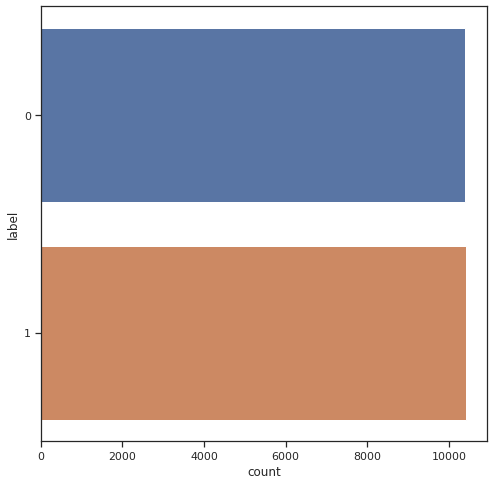

In [231]:
# yes would be no changes after cleaning of text but lets see if any change
plt.figure(figsize = (8, 8))
sns.countplot(y = "label", data = df_train)

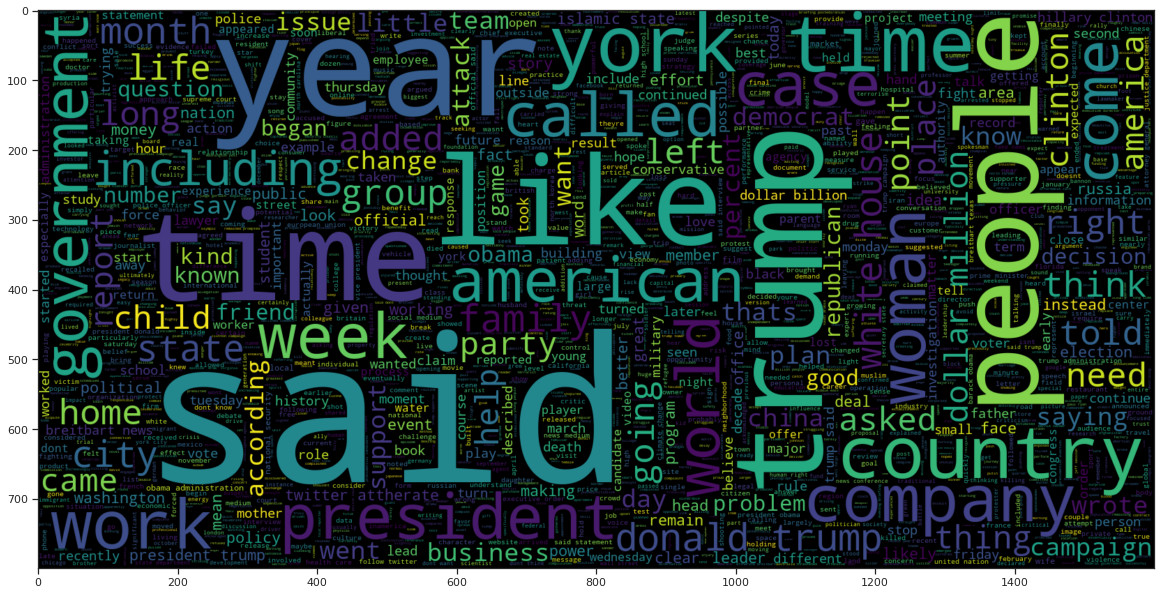

In [232]:

# Plotting The Word Cloud For Text That Is Real
# it will provide us the higest freq of words 

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df_train[df_train.label == 0].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

In [233]:
# Punkt Sentence Tokenizer. This tokenizer divides a text into a list of sentences
#import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [234]:
# Determining The Maximum Number Of Words In Any Document Required To Create Word Embeddings 
# This will help us to create embeddings and paddign to create common length of curp
maxlen = -1
for doc in df_train.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any news is =", maxlen)

The maximum number of words in any news is = 9549


In [235]:

# Visualizing The Distribution Of Number Of Words In A Text
import plotly.express as px
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df_train.clean_joined], nbins = 60)
fig.show()

In [236]:
# Splitting Data Into Test And Train , we have another data called test but splitting train data and considering that another 
# CSV sheet provided is new data (test.csv)

x_train, x_test, y_train, y_test = train_test_split(df_train.clean_joined, df_train.label, test_size = 0.2)

In [237]:
len(x_train)

16640

In [238]:
len(x_test)

4160

In [239]:
len(x_train[0])

2987

In [240]:
len(x_test[:1])

1

In [42]:
# This new data is created by loading test.csv, so that we can preprocess and clean so that we can use it 
# for new data preduction with model
new_date = df_test['clean_joined'].values

***Preparing the Embedding Layer:*** 
we will use the Tokenizer class from the keras.preprocessing.text module to create a word-to-index dictionary. In the word-to-index dictionary, each word in the corpus is used as a key, while a corresponding unique index is used as the value for the key
1. If you view the X_train variable in variable explorer, you will see that it contains 16640 lists where each list contains integers. Each list actually corresponds to each sentence in the training set. You will also notice that the size of each list is different but the 0th index has length 2956. This is because sentences have different lengths.

In [241]:
# Creating A Tokenizer To Tokenize The Words And Create Sequences Of Tokenized Words
# like Consider this string - "I like cat" => after we perform tokenization on this string => We get [‘I’, ‘like’, cat’]
tokenizer = Tokenizer(num_words = total_words)

#tokenizer.fit_on_texts(df.clean_joined)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

In [62]:
#max_length = max([len(s.split()) for s in df_train.clean_joined])

***Checking Vocab size :***
variable now contains a value 168461 which means that our corpus has 168461 unique words.

In [242]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
vocab_size

209776

In [243]:
# This is required as to test new data for Prediction
new_date_sequences = tokenizer.texts_to_sequences(new_date)

In [244]:
# To conform whether our sequences are created or not
print("The encoding for document\n",df_train.clean_joined[0],"\n is : ",train_sequences[0])

The encoding for document
 house aide comeys letter jason chaffetz tweeted house aide comeys letter jason chaffetz tweeted darrell lucus october subscribe jason chaffetz stump american fork utah image courtesy michael jolley available creative commonby license apology keith olbermann doubt worst person world weekfbi director james comey according house democratic aide look like know seconworst person turn comey sent noinfamous letter announcing looking email related hillary clinton email server ranking democrat relevant committee hear comey tweet republican committee chairman know comey notified republican chairman democratic ranking member house intelligence judiciary oversight committee agency reviewing email recently discovered order contained classified information long letter went oversight committee chairman jason chaffetz political world ablaze tweet informed learned existence email appear pertinent investigation case reopened jason chaffetz attherate jasoninthehouse october cou

***Padding creation for Embeddings ***
We set the maximum size of each list to 40. You can try a different size. The lists with size greater than 40 will be truncated to 40. For the lists that have length less than 40, we will add 0 at the end of the list until it reaches the max length as it is post padding. This process is called padding.

In [245]:
# Adding Padding
padded_train = pad_sequences(train_sequences,maxlen = 100, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 100, truncating = 'post')

In [246]:
#RSA
# now to create embeddings all of our docs need to be of same length. hence we can pad the docs with zeros.
print("No of padded documents: ",len(padded_train))

No of padded documents:  16640


The maximum number of words in any document is = 13342 

No of padded documents:  16640

In [247]:
for i,doc in enumerate(padded_train[:2]):
     print("The padded encoding for document",i+1," is : ",doc)

The padded encoding for document 1  is :  [  367  4277 15801  2439 12007  1172  1175     8   367  1015   103 15801
   367  1163   918   204   205  1637  4277  1031  2117    28    73  2245
  2439  6403   160     3    22   155   103  1015    86   129   409   244
  1567 50977    33   944 33188  8772  3204     8  1639  3978   732  2572
  1518 12008  1081   367  4277   277   677   103  1667     9  4051   324
   179  2439  1891  4745  1261     9  3978  2572  4238    86  2306   298
     9   367   361    11   245   317  1667   317  6325   196  2470   984
   103   779 86995   204  7697 62142  9564   204   918 11519  7635   918
   118   115  3084  1662]
The padded encoding for document 2  is :  [35822    91    37   593   615   593   478  4239 86999  6405   196  5868
 87000   246   449   340  1756  1938 35823   690   594   478    94   111
   586 14577  1269 87001    81 44031   572  1756   450    64  1109  1562
  8617  1795 10779 11520  1887    45  1687  2911  1323 87002   645 22180
  1865   596  

Simple deep neural network : Bidirectional LSTM is a type of LSTM which learns from the input sequence from both forward and backward directions. The final sequence interpretation is the concatenation of both forward and backward learning passes.
1. First of all, we have defined an embedding layer. The embedding layer converts the words into word vectors. For example, the word “apple” can be embedded as [0.2, 0.12, 0.45]
2. The number of dimensions is a hyper-parameter. The purpose of using word embeddings is to find better similarities between the words, this is where the one-hot encodings fail. Here we have chosen a dimension of 128.
3. The final layer is the output layer with sigmoid activation function since our problem is a binary classification problem we have used the sigmoid function.
4. We have used the Adam optimization function for backpropagation and we have used the binary cross-entropy loss function for loss and accuracy for metric. The loss function is used to optimize the model whereas the metric is used for our comparison

In [248]:
# Sequential Model
model = Sequential()

# Embeddidng layer
model.add(Embedding(total_words, output_dim = 128))

# Bi-Directional RNN and LSTM
model.add(Bidirectional(LSTM(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.1))  # RSA
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 128)         30926464  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 31,222,657
Trainable params: 31,222,657
Non-trainable params: 0
_________________________________________________________________


In [249]:
# Converting into arrray to support format for model fitting
y_train = np.asarray(y_train)

*TRAINING THE MODEL*
1. We used 5 epochs and a batch size of 64 to train. We use the padded sequences of the text as the features and the label as a target.
2.The validation_split of 0.1 means that 10% of the training data is used to find the training accuracy of the algorithm.


In [250]:
# Training the model
history  = model.fit(padded_train, y_train, batch_size = 128, validation_split = 0.2, epochs = 10)


Epoch 1/10
104/104 [==============================] - 108s 1s/step - loss: 0.2681 - acc: 0.8925 - val_loss: 0.1119 - val_acc: 0.9546
Epoch 2/10
104/104 [==============================] - 104s 1s/step - loss: 0.0367 - acc: 0.9884 - val_loss: 0.1512 - val_acc: 0.9507
Epoch 3/10
104/104 [==============================] - 102s 982ms/step - loss: 0.0054 - acc: 0.9986 - val_loss: 0.1401 - val_acc: 0.9585
Epoch 4/10
104/104 [==============================] - 102s 984ms/step - loss: 0.0022 - acc: 0.9995 - val_loss: 0.1763 - val_acc: 0.9513
Epoch 5/10
104/104 [==============================] - 104s 995ms/step - loss: 5.8579e-04 - acc: 0.9998 - val_loss: 0.2971 - val_acc: 0.9525
Epoch 6/10
104/104 [==============================] - 103s 986ms/step - loss: 1.3113e-04 - acc: 1.0000 - val_loss: 0.1813 - val_acc: 0.9546
Epoch 7/10
104/104 [==============================] - 103s 993ms/step - loss: 8.9184e-05 - acc: 1.0000 - val_loss: 0.2318 - val_acc: 0.9519
Epoch 8/10
104/104 [======================

In [251]:
# Here we can save build/Trained model in memory and can save training time and can be loaded for 
# preducting new data and this save model can be used as pipeline to predict and move way
# I'm going to write code for saving and loading model but would not going to use is as have memory issue
# in personal PC

# The model has a save method, which saves all the details necessary to reconstitute the model.
from keras.models import load_model

model.save('/content/drive/My Drive/data/nlpTxtCsf_model.h5')  # creates a HDF5 file 'nlpTxtCsf_model.h5'
# del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model_loaded = load_model('/content/drive/My Drive/data/nlpTxtCsf_model.h5')

# summarize model.
model_loaded.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 128)         30926464  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 31,222,657
Trainable params: 31,222,657
Non-trainable params: 0
_________________________________________________________________


In [252]:
# Making prediction : "padded_test" is the data for 20 split test data that we have spplitted 
pred = model.predict(padded_test)

In [253]:
# If The Predicted Value Is >0.95 (i.e., More Than 95%), It Is Real Else It Is Fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.95:
        prediction.append(1)
    else:
        prediction.append(0)

In [ ]:
#prediction

***MODEL SCORE*** 

To evaluate the performance of the model, we can simply pass the test set to the evaluate method of our model. prediction and y_test

In [254]:

# Getting The Accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

Model Accuracy :  0.9387019230769231


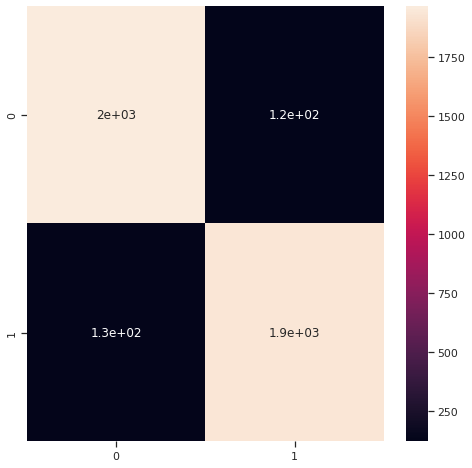

In [255]:
# Getting The Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (8, 8))
sns.heatmap(cm, annot = True)

In [256]:
# Evaluate the accuracy of our trained model
score = model.evaluate(pred, y_test,batch_size=64, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

65/65 [==============================] - 1s 3ms/step - loss: 0.7077 - acc: 0.4493
Test score: 0.7076644897460938
Test accuracy: 0.4492788314819336


In [263]:
from sklearn.metrics import classification_report, confusion_matrix
# Obtain predictions
predicted = model.predict(padded_test)
# Print classification report using predictions
print(classification_report(y_test, threshold_true(predicted)))

# Print confusion matrix using predictions
print(confusion_matrix(y_test, threshold_true(predicted)))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2087
           1       0.94      0.94      0.94      2073

    accuracy                           0.94      4160
   macro avg       0.94      0.94      0.94      4160
weighted avg       0.94      0.94      0.94      4160

[[1966  121]
 [ 134 1939]]


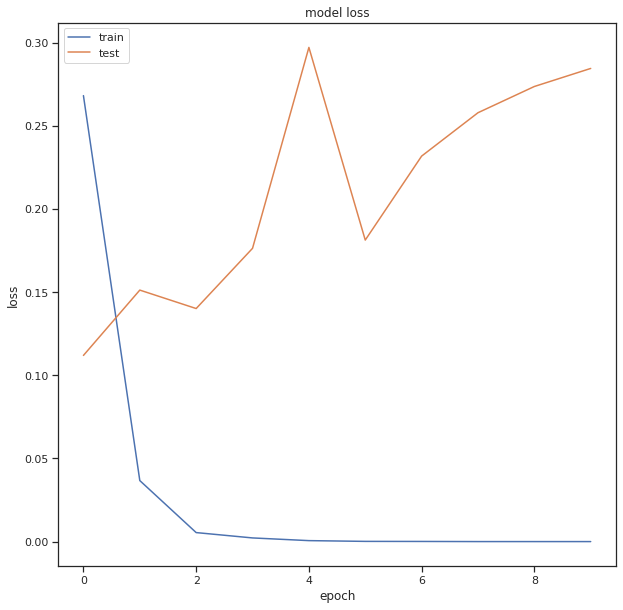

In [258]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

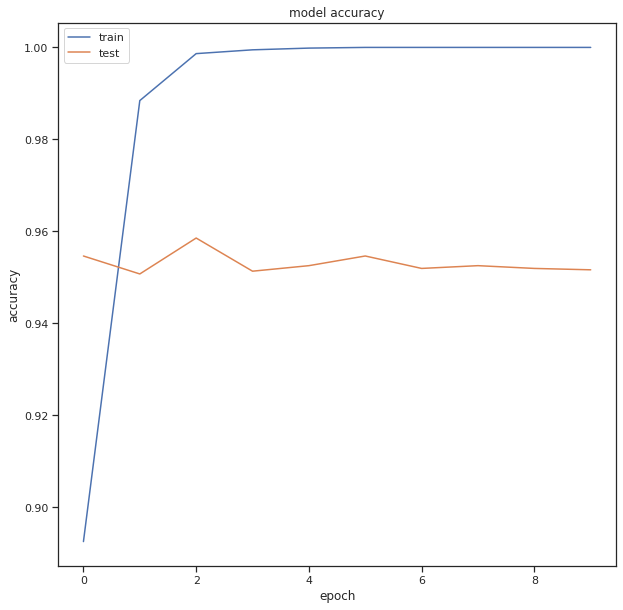

In [259]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [260]:
# This is the function used to predict new data 
def predict_fake(predict_news):
    new_seq = tokenizer.texts_to_sequences(predict_news)
    padded = pad_sequences(new_seq, maxlen = 100, padding = 'post', truncating = 'post')
    return (model.predict(padded))

In [261]:
# new_date
newPred = predict_fake(new_date)

In [262]:
def threshold_true(newPred):
  prediction = []
  for i in range(len(newPred)):
    if newPred[i].item() > 0.95:
        prediction.append(1)
    else:
        prediction.append(0)
  return prediction



In [264]:
df_test['pred_lbl'] = threshold_true(newPred)

In [265]:
df_test.head(5)

,id,title,author,text,original,clean,clean_joined,clean_stem,clean_lema,pred_lbl
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...",specter of trump loosens tongues if not purse ...,"[specter, trump, loosens, tongues, purse, stri...",specter trump loosens tongue purse string sili...,"[specter, trump, loosen, tongu, purs, string, ...","[specter, trump, loosens, tongue, purse, strin...",0
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...,russian warships ready to strike terrorists ne...,"[russian, warships, ready, strike, terrorists,...",russian warship ready strike terrorist near al...,"[russian, warship, readi, strike, terrorist, n...","[russian, warship, ready, strike, terrorist, n...",1
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,hasha nodapl native american leaders vow to s...,"[hasha, nodapl, native, american, leaders, sta...",hasha nodapl native american leader stay winte...,"[hasha, nodapl, nativ, american, leader, stay,...","[hasha, nodapl, native, american, leader, stay...",1
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...",tim tebow will attempt another comeback this t...,"[tebow, attempt, comeback, time, baseball, yor...",tebow attempt comeback time baseball york time...,"[tebow, attempt, comeback, time, basebal, york...","[tebow, attempt, comeback, time, baseball, yor...",0
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,keiser report meme wars e mins ago views co...,"[keiser, report, meme, wars, mins, views, comm...",keiser report meme war min view comment like t...,"[keiser, report, meme, war, min, view, comment...","[keiser, report, meme, war, min, view, comment...",1


In [266]:
dfResult = df_test.drop(['title','author','text','original','clean','clean_joined','clean_stem','clean_lema'], axis = 1)

In [267]:
dfResult[:5]

,id,pred_lbl
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1


In [268]:
# Saving the  predicted dataframe form test.csv ID and predicted label as "pred_lbl"
dfResult.to_csv('/content/drive/My Drive/data/LSTM_pred_submit.csv', index=False)